In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.modeling import fitting
from astropy.coordinates import Angle

%matplotlib inline

### Generate fake data / image (Gaussian)

In [2]:
imgsize = 256

In [3]:
x0, y0 = imgsize/2, imgsize/2 # center
a, b = 20, 10 # stddev
theta = Angle(30, 'deg') # position angle
amplitude=1/1256.6370614343305

e = Gaussian2D(amplitude=amplitude, x_mean=x0, y_mean=y0, x_stddev=a, y_stddev=b, theta=theta.radian)

In [4]:
y, x = np.mgrid[0:imgsize, 0:imgsize]

f = e(x, y)

In [5]:
np.sum(f)

0.99999999999999978

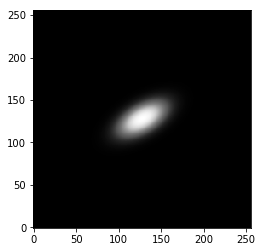

In [6]:
fig, ax = plt.subplots(1, 1)
ax.imshow(f, origin='lower', interpolation='none', cmap='Greys_r')

In [7]:
F = np.fft.fft2(f)
print(F.shape)

(256, 256)


In [8]:
F_mag = np.abs(np.fft.fftshift(F))
F_phase = np.angle(np.fft.fftshift(F))

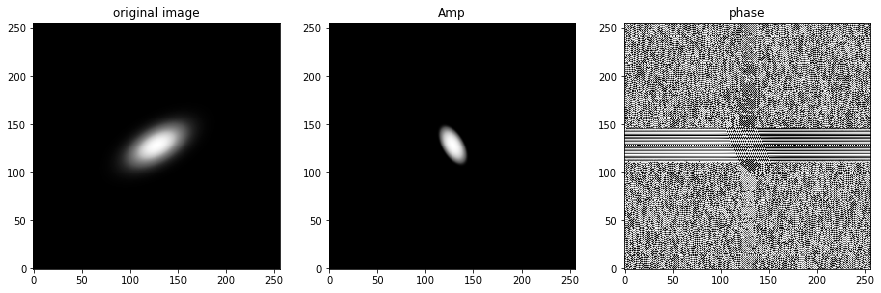

In [9]:
plt.rc("font", size=10)
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(f, origin='lower', cmap='Greys_r')
plt.title("original image")

plt.subplot(132)
plt.imshow(np.log(F_mag + 0.0000001), origin='lower', cmap='Greys_r') # +small constant, to remove 0 (warning)
plt.title("Amp")

plt.subplot(133)
plt.imshow(F_phase, origin='lower', cmap='Greys_r')
plt.title("phase")

plt.show()

1.0000000000000004

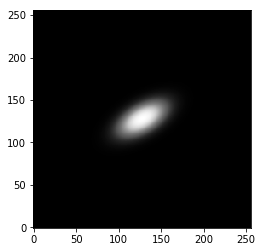

In [10]:
# inverse again to check
Fnew = (F_mag)*np.exp(1j*F_phase)
fnew = np.fft.ifft2(np.fft.ifftshift(Fnew))
plt.imshow(np.abs(fnew), origin='lower', cmap='Greys_r')
np.sum(np.abs(fnew))

In [11]:
uvdist = []
amp = []
phase = []

center = imgsize/2 - 0.5, imgsize/2 - 0.5

for i, row in enumerate(F_mag):
    for j, col in enumerate(row):
        # calculate distance
        dist = np.sqrt((i-center[0])**2 + (j-center[1])**2)
        uvdist.append(dist)
        amp.append(F_mag[i,j])
        phase.append(F_phase[i, j])

In [12]:
np.sum(F_mag)

52.151891752946845

In [13]:
np.sum(amp)

52.151891752946845

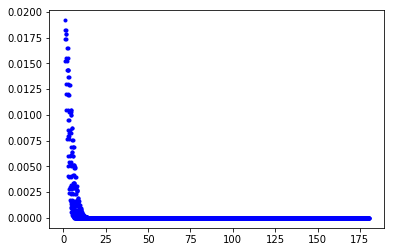

In [14]:
plt.plot(uvdist, amp/np.sum(amp), 'b.')

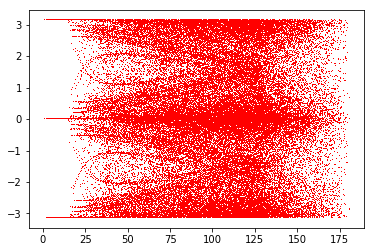

In [15]:
plt.plot(uvdist, phase, 'r,')

Short baseline (<15) have phase 0, $\pi$, and $-\pi$

(0, 15)

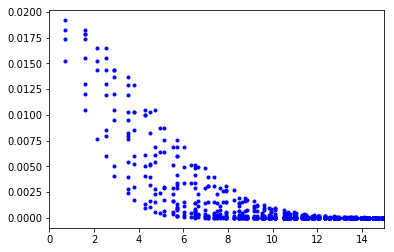

In [16]:
# zoom in
plt.plot(uvdist, amp/np.sum(amp), 'b.')
plt.xlim([0, 15])

### Sampling (gaussian)

dominant short baseline, because the source is extended

In [17]:
nsample = 100
# sample in uv is 2*nsample
# it is possible to have same number (alias), not checked, so less than 2*nsample

u = np.random.normal(imgsize/2, 5, nsample) 
v = np.random.normal(imgsize/2, 5, nsample)
u = np.floor(u).astype(int)
v = np.floor(v).astype(int)

# mirroring
umirror = (imgsize-1)-u #-u
vmirror = (imgsize-1)-v #-v

# combine (mask)
uc = np.zeros((imgsize, imgsize), dtype=np.int)
uc[u,v] = 1
uc[umirror, vmirror] = 1
print uc.shape

(256, 256)


([], <a list of 0 Text yticklabel objects>)

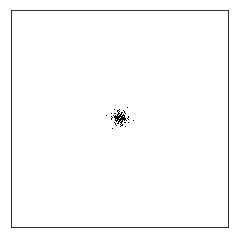

In [18]:
### UV-coverage
plt.imshow(uc, cmap="Greys")
plt.xticks([]); plt.yticks([])

In [19]:
# visibility
vis = uc * (F_mag * np.exp(1j*F_phase)) # sampling by masking

In [20]:
center = imgsize/2 - 0.5, imgsize/2 - 0.5
print "Real number of sample = ", len(vis[np.abs(vis)>0])
print "Number of baseline = ", len(vis[np.abs(vis)>0])/2

Real number of sample =  158
Number of baseline =  79


In [21]:
uvdist = []
amp = []
phase = []

for i, row in enumerate(uc):
    for j, col in enumerate(row):
        if uc[i,j] == 1:
            # calculate distance
            dist = np.sqrt((i-center[0])**2 + (j-center[1])**2)
            uvdist.append(dist)
            amp.append(F_mag[i,j])
            phase.append(F_phase[i, j])

In [22]:
np.sum(amp)

35.29539640142707

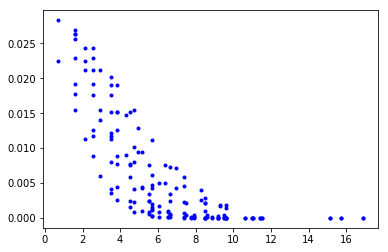

In [23]:
plt.plot(uvdist, amp/np.sum(amp), 'b.')

2 "gaussian" (small and large), from 2 dimensional "gaussian" with different sigma

(0, 255)

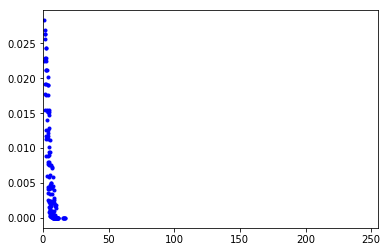

In [24]:
plt.plot(uvdist, amp/np.sum(amp), 'b.')
plt.xlim([0, 255])

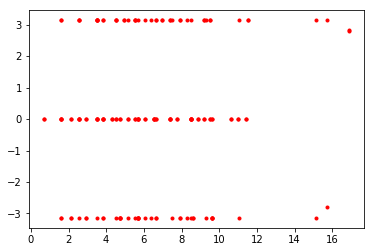

In [25]:
plt.plot(uvdist, phase, 'r.')

sample only/dominant short baseline

In [26]:
fnew = np.fft.ifft2(np.fft.ifftshift(vis))
np.sum(np.abs(fnew))

2.3437811672283675

In [27]:
#fnew = fnew/np.sum(np.abs(fnew)) # normalize
#np.sum(np.abs(fnew))

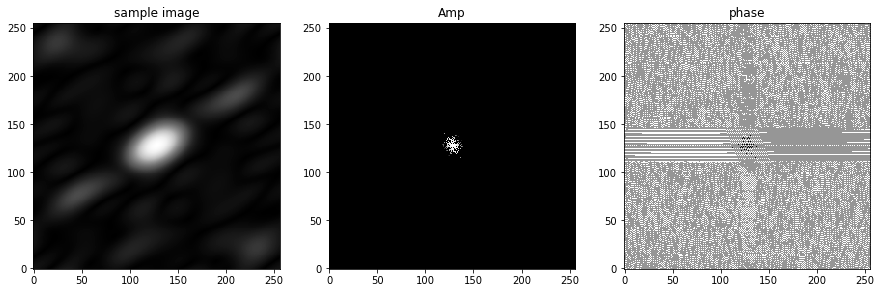

In [28]:
plt.rc("font", size=10)
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(np.abs(fnew), origin='lower', cmap='Greys_r')
plt.title("sample image")

plt.subplot(132)
plt.imshow(np.log(np.abs(vis) + 0.000001), origin='lower', cmap='Greys_r') # +small constant, to remove 0 (warning)
plt.title("Amp")

plt.subplot(133)
plt.imshow(np.angle(vis), origin='lower', cmap='Greys_r')
plt.title("phase")

plt.show()

### Fitting (in image plane)

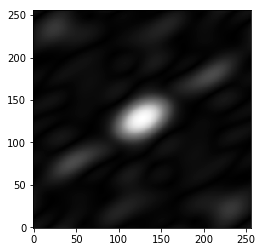

In [29]:
fnew = np.abs(fnew)
plt.imshow(fnew, origin='lower', cmap="Greys_r")

In [30]:
# initial guess
x0, y0 = imgsize/2 - 5, imgsize/2 + 5 # center
a, b = 20 + 5, 10 - 5 # stddev
theta = Angle(30 + 5, 'deg') # position angle
amplitude=1/ (1256.6370614343305 - 5)

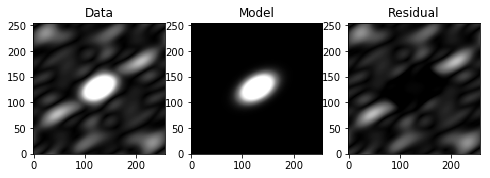

In [31]:
# Fit the data using astropy.modeling
p_init = Gaussian2D(amplitude=amplitude, x_mean=x0, y_mean=y0, x_stddev=a, y_stddev=b, theta=theta.radian)
fit_p = fitting.LevMarLSQFitter() # with LM fit

p = fit_p(p_init, x, y, fnew)

# Plot the data with the best-fit model
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(fnew, origin='lower', cmap="Greys_r", vmin=0, vmax=2e-4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', cmap="Greys_r", vmin=0, vmax=2e-4)
plt.title("Model")
plt.subplot(1, 3, 3)

residual = fnew - p(x, y)
plt.imshow(residual, origin='lower', cmap="Greys_r", vmin=0, vmax=2e-4)
plt.title("Residual")

In [32]:
print "Total: ", np.sum(fnew)

print "Model: ", np.sum(p(x,y))
print "Residual: ", np.sum(residual)
print np.sum(p(x,y)) + np.sum(residual)

Total:  2.34378116723
Model:  0.890669969698
Residual:  1.45311119753
2.34378116723


In [33]:
print "Fitting result: ", p.amplitude.value, p.x_mean.value, p.y_mean.value, p.x_stddev.value, p.y_stddev.value, p.theta.value

Fitting result:  0.000533377355092 128.0 128.0 21.0491701277 12.6260466492 0.531330228551


In [34]:
# Compare to True value
x0, y0 = imgsize/2, imgsize/2 # center
a, b = 20, 10 # stddev
theta = Angle(30, 'deg') # position angle
amplitude=1/1256.6370614343305

print "Real value: ", amplitude, x0, y0, a, b, theta.radian

Real value:  0.00079577471546 128 128 20 10 0.523598775598


Loss in amplitude -> That is why we need Total Power observation.

### Fitting (in uv plane)

+ How to fit complex number?
+ use only sampled visibility
+ Need to add noise

In [35]:
vis

array([[ 0.+0.j, -0.+0.j, -0.+0.j, ...,  0.+0.j, -0.+0.j,  0.+0.j],
       [-0.+0.j,  0.+0.j,  0.+0.j, ..., -0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -0.+0.j,  0.-0.j, ...,  0.-0.j,  0.-0.j, -0.+0.j],
       ..., 
       [ 0.+0.j, -0.+0.j,  0.+0.j, ...,  0.-0.j,  0.+0.j,  0.-0.j],
       [ 0.+0.j,  0.+0.j, -0.+0.j, ...,  0.+0.j, -0.+0.j,  0.+0.j],
       [ 0.-0.j,  0.+0.j,  0.+0.j, ..., -0.+0.j,  0.+0.j,  0.-0.j]])

In [36]:
np.abs(vis)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [37]:
np.angle(vis)

array([[ 0.        ,  3.14159265,  3.14159265, ...,  0.        ,
         3.14159265,  0.        ],
       [ 3.14159265,  0.        ,  0.        , ...,  3.14159265,
         0.        ,  0.        ],
       [ 0.        ,  3.14159265, -0.        , ..., -0.        ,
        -0.        ,  3.14159265],
       ..., 
       [ 0.        ,  3.14159265,  0.        , ..., -0.        ,
         0.        , -0.        ],
       [ 0.        ,  0.        ,  3.14159265, ...,  0.        ,
         3.14159265,  0.        ],
       [-0.        ,  0.        ,  0.        , ...,  3.14159265,
         0.        , -0.        ]])

In [38]:
uvdist = []
amp = []
phase = []

center = imgsize/2 - 0.5, imgsize/2 - 0.5
F_mag = np.abs(vis)
F_phase = np.angle(vis)

for i, row in enumerate(F_mag):
    for j, col in enumerate(row):
        # calculate distance
        dist = np.sqrt((i-center[0])**2 + (j-center[1])**2)
        uvdist.append(dist)
        amp.append(F_mag[i,j])
        phase.append(F_phase[i, j])

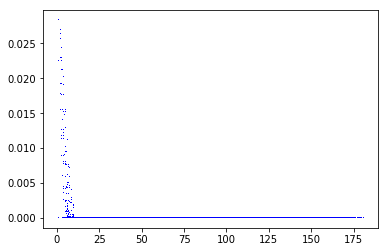

In [39]:
plt.plot(uvdist, amp/np.sum(amp), 'b,')

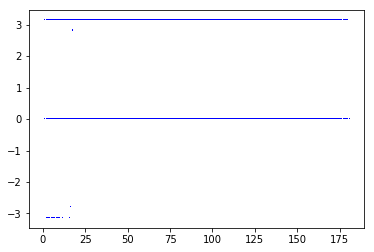

In [40]:
plt.plot(uvdist, phase, 'b,')

In [41]:
# model
# gaussian in Fourier space
model = Gaussian2D()

In [42]:
# log likelihood
def lnlike(theta, vis): #vis_error?
    pass

In [43]:
# log prior
def lnprior(theta):
    pass

In [44]:
# log posterior
def lnprob(theta, vis): # vis error?
    pass